In [1]:
#import ReadRawMHD as rR
import mapping_noRot as mappNR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import SimpleITK as sitk
import time
import os
t1 = time.time()

In [2]:
# # # # # Input # # # # #
# Input imaging data
# FE version
models = ['00_L50_S50_D30', '01_L50_S50_D35', '02_L50_S50_D40', '03_L50_S50_D45', '04_L50_S50_D27',  # 0, 1, 2, 3, 4
          '10_L50_S00_D30', '11_L50_S00_D35', '12_L50_S00_D40', '13_L50_S00_D45', '14_L50_S00_D27', '15_L50_S00_D44',
          '31_L50_S50_D35', '43_L50_S00_D45',  # 11, 12
          '50_L50_S00_D30', '55_L50_S00_D30',  # 13, 14
          '63_L50_S50_D45', '74_L50_S50_D45', '75_L50_S50_D45',  '76_L50_S50_D45', '77_L50_S50_D45',  # 15, 16, 17, 18, 19
          '80_L50_S50_D45', '83_L50_S50_D45']  # 20, 21


model_code = models[20]  # FEA model name
print('Model: ' + str(model_code))
sample_code = 'S131318_L1_right'  # Experimental sample. contains number and sample name
# ExpScrew no use anymore.
ExpScrew = 'P'  # T or P, site from experiment. Two input files (SimScrew Ti and PEEK) will always be generated

Model: 80_L50_S50_D45


In [3]:
# Specify file locations
path_project = '/home/biomech/Documents/01_Icotec/'  # General project folder
path_ct = path_project + '01_Experiments/02_Scans/' + sample_code + '/04_Registered/'  # Folder of CT data
path_fea = path_project + '02_FEA/98_Pilots/' + sample_code + '/' + model_code + '/'  # Folder of FEA files
file_bone = [filename for filename in os.listdir(path_ct + '/') if filename.endswith('image.mhd') and str(sample_code) in filename][0]
print(file_bone)

S131318_L1_right_screw_image.mhd


In [4]:
# # # # # Input # # # # #
# Input FEA data
Input = {}
Input['Project_Folder'] = path_project
Input['FEA_loc'] = path_fea  # path to FEA files
Input['Model_Code'] = model_code  # model code (FEA model name)
Input['Screw'] = ExpScrew  # which site of scan will be processed
Input['Resolution'] = 0.0606995  # scan resolution, should be 0.0606995 for HR-pQCT II

Input['Load_mode'] = 'd'  # no effect 'd' or 'f', displacement or force controlled
## ********* EXCLUDED (line 357 in mapping.py)

Input['d_dir'] = '-'  # displ direction (negative corresponds to experiment, positive = inverse). Input: '-' or '+'
Input['d_max'] = 1  # peak displ

Input['Friction'] = 0.2  # friction between screw and bone
Input['Mapping_Diameter'] = 2  # diameter of sphere for mapping, in mm. should be larger than element size

# Check if folder exists, otherwise create it
isExist = os.path.exists(Input['FEA_loc'])
if not isExist:
    os.makedirs(Input['FEA_loc'])
    print('New directory created: ' + Input['FEA_loc'])

# Submit on cortex or ubelix?
# -> Other parameters as e-mail, runtime, memory etc. can be changed in the template file
Input['Submit'] = 'ubelix'
mappNR.write_submit(Input)

# Take screw axis or points from PMMA area
screw_axis = 1

# Write output images? segmented image and mask, for visual check
write_output = 1

In [5]:
# Write mesh input file
mappNR.write_mesh(Input)  # Original input file, path for mesh.inp


Finished extracting mesh file.


In [6]:
bone = {}
bone = mappNR.readInpBoneDummy(bone, Input)  # Read bone mesh from abaqus. Read elements, nodes
bone = mappNR.load_BVTVdata(bone, path_ct + file_bone)
bone = mappNR.boneMeshMask(bone, Input)  # Create mask from abaqus bone mesh

BoneMeshMask


insBefore: [ 88 378  71]
insAfter: [143 127 216]
mask dimension: [190 289 824]
bone dimension: [ 421  794 1111]
new mask dimension: [ 421  794 1111]


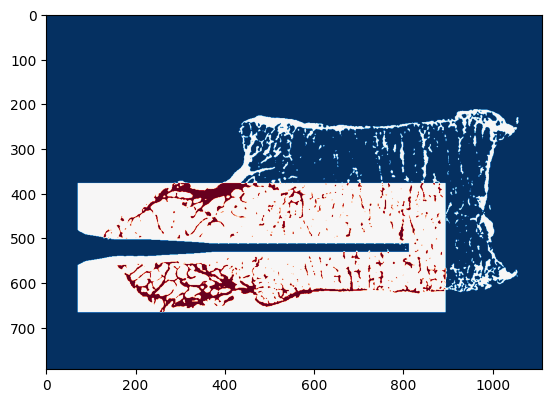

In [13]:
# Read mask
imMask = sitk.ReadImage(Input['FEA_loc'] + Input['Model_Code'] + Input['Screw'] + '_mask.mhd')
imMask_np = np.transpose(sitk.GetArrayFromImage(imMask), [2, 1, 0])
orM = np.array(imMask.GetOrigin())
orB = np.array(bone['GreyImage'].GetOrigin())
insBefore = np.rint(abs(orB-orM)/Input['Resolution']).astype(int)
bone['insBefore'] = insBefore
print('insBefore: ' + str(insBefore))
dimMask = np.array(imMask.GetSize())
dimBone = np.array(bone['GreyImage'].GetSize())
insAfter = (dimBone-dimMask-insBefore).astype(int)
bone['insAfter'] = insAfter
print('insAfter: ' + str(insAfter))
print('mask dimension: ' + str(dimMask))
print('bone dimension: ' + str(dimBone))
imMask_np_corr = imMask_np
#print(np.zeros((insBefore[0], dimMask[1], dimMask[2])))
imMask_np_corr = np.append(np.insert(imMask_np_corr, 0, np.zeros((insBefore[0], imMask_np_corr.shape[1], imMask_np_corr.shape[2])), 0), np.zeros((insAfter[0], imMask_np_corr.shape[1], imMask_np_corr.shape[2])), 0)
#print('current mask dimension: ' + str(np.array(imMask_np_corr.shape)))

imMask_np_corr = np.append(np.insert(imMask_np_corr, 0, np.zeros((insBefore[1], imMask_np_corr.shape[0], imMask_np_corr.shape[2])), 1), np.zeros((imMask_np_corr.shape[0], insAfter[1], imMask_np_corr.shape[2])), 1)
#print('current mask dimension: ' + str(np.array(imMask_np_corr.shape)))

imMask_np_corr = np.append(np.insert(imMask_np_corr, 0, np.zeros((insBefore[2], imMask_np_corr.shape[0], imMask_np_corr.shape[1])), 2), np.zeros((imMask_np_corr.shape[0], imMask_np_corr.shape[1], insAfter[2])), 2)
print('new mask dimension: ' + str(np.array(imMask_np_corr.shape)))

imSum = imMask_np_corr + bone['BVTVscaled']
plt.figure()
plt.imshow(imSum[200, :, :], cmap=cm.RdBu_r)

In [8]:
bone['MASK'] = imMask_np_corr
if write_output:
    img_seg=sitk.GetImageFromArray(np.transpose(bone['BVTVscaled'], [2, 1, 0]))
    img_seg.SetOrigin(bone['GreyImage'].GetOrigin())
    img_seg.SetSpacing(bone['GreyImage'].GetSpacing())
    sitk.WriteImage(img_seg, path_fea + sample_code + '_seg.mhd')
    print('Segmented image saved.')
del img_seg
# del bone['GreyImage']

Segmented image saved.


In [9]:
mappNR.HFE_mapping_trans(bone, Input)

... start material mapping with copying boundary layers as ghost layers

offset2COS[-11.091556  -31.694411   -4.3096645]

cog_real: [12.11801595 31.52038493 49.9346645 ]

Points:
199.63881123959422
519.2857425308281
822.6536380036082
... material mapping element 1/4388
cog_real: [12.03769592 31.20135108 49.9346645 ]

Points:
198.31557521042114
514.0297873260901
822.6536380036082
... material mapping element 2/4388
cog_real: [12.1178669 31.5214109 51.1846645]

Points:
199.63635575299384
519.3026449451808
843.2468883598714
... material mapping element 3/4388
cog_real: [12.03645   31.2035345 51.1846645]

Points:
198.29504926218746
514.0657583398547
843.2468883598714
... material mapping element 4/4388
cog_real: [11.86501192 30.96699285 49.9346645 ]

Points:
195.4706847628571
510.1688293074903
822.6536380036082
... material mapping element 5/4388
cog_real: [11.59251881 30.81364449 49.9346645 ]

Points:
190.98148450157086
507.64247637789447
822.6536380036082
... material mapping element 6/4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




cog_real: [11.71247868 26.70873145 47.36132464]

Points:
192.9577688917737
440.0156747007801
780.2588924949957
... material mapping element 3658/4388
cog_real: [13.00319235 26.66691669 46.0358936 ]

Points:
214.22169060143628
439.32679326847824
758.4229458232768
... material mapping element 3659/4388
cog_real: [11.7092415  26.71112276 46.04481217]

Points:
192.90443768832466
440.05507063484873
758.5698756991407
... material mapping element 3660/4388
cog_real: [12.99651906 26.67166701 44.7146957 ]

Points:
214.11175119481646
439.40505294936526
736.6567384410085
... material mapping element 3661/4388
cog_real: [11.70711959 26.71264592 44.72194916]

Points:
192.86948018359232
440.0801640952561
736.7762363775647
... material mapping element 3662/4388
cog_real: [12.99361077 26.67373587 43.3906404 ]

Points:
214.06383833033766
439.4391365003007
714.8434567830047
... material mapping element 3663/4388
cog_real: [11.70612195 26.71335557 43.39696194]

Points:
192.8530446320163
440.091855353009

{'elems': {1: <MedtoolFunctions.med_classes.element at 0x7fe3754eb7f0>,
  2: <MedtoolFunctions.med_classes.element at 0x7fe3754eb820>,
  3: <MedtoolFunctions.med_classes.element at 0x7fe3754eb850>,
  4: <MedtoolFunctions.med_classes.element at 0x7fe3754eb880>,
  5: <MedtoolFunctions.med_classes.element at 0x7fe3754eb8b0>,
  6: <MedtoolFunctions.med_classes.element at 0x7fe3754eb8e0>,
  7: <MedtoolFunctions.med_classes.element at 0x7fe3754eb910>,
  8: <MedtoolFunctions.med_classes.element at 0x7fe3754eb940>,
  9: <MedtoolFunctions.med_classes.element at 0x7fe3754eb970>,
  10: <MedtoolFunctions.med_classes.element at 0x7fe3754eb9a0>,
  11: <MedtoolFunctions.med_classes.element at 0x7fe3754eb9d0>,
  12: <MedtoolFunctions.med_classes.element at 0x7fe3754eba00>,
  13: <MedtoolFunctions.med_classes.element at 0x7fe3754eba30>,
  14: <MedtoolFunctions.med_classes.element at 0x7fe3754eba60>,
  15: <MedtoolFunctions.med_classes.element at 0x7fe3754eba90>,
  16: <MedtoolFunctions.med_classes.elem

In [10]:
# Write final input file
mappNR.HFE_inp_creator(Input)
if not write_output:
    os.remove(Input['FEA_loc'] + Input['Model_Code'] + Input['Screw'] + '_elsets.inp')
    os.remove(Input['FEA_loc'] + Input['Model_Code'] + Input['Screw'] + '_materials.inp')
    os.remove(Input['FEA_loc'] + Input['Model_Code'] + '_mesh.inp')
    os.remove(path_fea + model_code + ExpScrew + '_mask.mhd')
    os.remove(path_fea + model_code + ExpScrew + '_mask.raw')

Section set to Ti.
Section set to PEEK.
End HFE_inp_creator


In [11]:
tRun = time.time()-t1
if tRun >= 3600:
    print('Execution time: ' + str(int(tRun/3600)) + ' h ' + str(int(np.mod(tRun, 3600)/60)) + ' min '+ str(round(np.mod(tRun, 60), 1)) + ' sec.')
elif tRun >= 60:
    print('Execution time: ' + str(int(tRun/60)) + ' min '+ str(round(np.mod(tRun, 60), 1)) + ' sec.')
else:
    print('Execution time: ' + str(round(tRun, 1)) + ' sec.')

Execution time: 3 min 29.0 sec.


In [12]:
print(bone['MaskX'])
print(bone['MaskY'])
print(bone['MaskZ'])
print(bone['insBefore'][0]*Input['Resolution'])

[-5.75  5.75]
[-8.75  8.75]
[ 0. 50.]
5.341556000000001
